In [1]:
import sys, os, time, shutil, random
from pathlib import Path
if '_cwd' not in locals():
    _cwd = os.getcwd()
    os.chdir(Path(_cwd)/'..')

import numpy as np
%matplotlib notebook
import matplotlib.pyplot as plt
from tabulate import tabulate
import matplotlib.patches as mpatches
from tqdm.notebook import tqdm
from scipy import misc, signal

from sklearn.neighbors import NearestNeighbors
import networkx as nx
import cv2
import random
import ctypes
from scipy.signal import convolve2d, correlate2d
import ipywidgets as widgets
from IPython.display import display, clear_output
from collections import Counter
import io

import scipy.sparse as sp
from scipy.optimize import linear_sum_assignment

from omnibelt import load_yaml, save_yaml, multi_index

from skimage import data
from skimage.filters import threshold_otsu
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops
from skimage.segmentation import *
from skimage.segmentation import watershed, expand_labels
from skimage.morphology import closing, square, dilation
from skimage.color import label2rgb
from PIL import Image
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [2]:
root = Path('extra/balkans')

In [3]:
rgba = Image.open(root/'borders.png').convert('RGBA')
rgba = np.asarray(rgba)
rgb = rgba[...,:3]
lbls = np.array(Image.open(root/'regions.png'))
tileimg = np.array(Image.open(root/'tiles.png'))
lbls.shape, rgb.shape, tileimg.shape

((4442, 4405), (4442, 4405, 3), (4442, 4405))

In [4]:
_fsize = (6,6)
def showx(im, cover=lbls):
    plt.figure(figsize=_fsize)
    try:
        plt.imshow(im.astype(int))
        if cover is not None:
            plt.imshow(cover%1000, alpha=0., zorder=10)
    except ValueError:
        plt.imshow(im)
    
    plt.axis('off')
    plt.subplots_adjust(0,0,1,1)
    
    

# def get_highlight(rgb, mask, opacity=0.2):
#     alpha = np.zeros_like(mask).astype(np.uint8)
    
#     img = rgb.astype(np.uint8)
    
#     alpha[mask!=0] = 255
#     alpha[mask==0] = int(255*opacity)
    
#     H,W,C = img.shape
    
#     if C == 4:
#         img[...,-1] = alpha
#     else:
#         img = np.concatenate([img, alpha.reshape(H,W,1)],-1)
#     return img
    
# def highlight(rgb, mask, opacity=0.2, cover=lbls):
#     img = get_highlight(rgb, mask, opacity=opacity)
#     return showx(img, cover=cover)
    
    
    
def get_highlight(mask, _rgb=rgb, opacity=0.2):
    alpha = np.zeros_like(mask).astype(np.uint8)
    
    img = _rgb.astype(np.uint8)
    
    alpha[mask!=0] = 255
    alpha[mask==0] = int(255*opacity)
    
    H,W,C = img.shape
    
    if C == 4:
        img[...,-1] = alpha
    else:
        img = np.concatenate([img, alpha.reshape(H,W,1)],-1)
    return img
    
def highlight(mask, _rgb=rgb, opacity=0.2, cover=lbls):
    img = get_highlight(mask, _rgb, opacity=opacity)
    return showx(img, cover=cover)
    


    
# showx(lbls)

In [50]:
graph = load_yaml(root/'graph.yaml')
nodeIDs = {node['ID']:node for node in graph.values()}
regs = {node['name']:node for node in graph.values()}

bgs = load_yaml(root/'bgs.yaml')
bgIDs = {node['ID']:node for node in bgs}

len(graph), len(bgs)

(97, 17)

In [51]:
nodelbls = lbls.copy()
for ID, bg in bgIDs.items():
    nodelbls[ID==nodelbls] = regs[bg['island']]['ID'] if 'island' in bg else 0
filled = expand_labels(nodelbls,50)
(filled==0).sum(), filled.max()

(532863, 97)

In [7]:
# showx(filled,None)

In [48]:
def asign_locs(locimg, regimg, multi=False):
    
    ucnt = {idx:Counter(regimg[locimg==idx]) for idx in tqdm(range(1,locimg.max()+1))}
    
    ridx, cidx, vidx = zip(*[(r,c,v) for r, cs in ucnt.items() for c, v in cs.items()])
    Us = sp.csr_matrix((vidx, (ridx, cidx))) # sparse csr matrix
    Us = Us.todense().base

    if multi:
        ns = Us.argmax(1)
        us = np.arange(len(ns))
        
        ns = ns.tolist()
        us = us.tolist()
    
    else:
        offset = 0
        us, ns = [], []
        U = Us.copy()
        uids = np.arange(len(U))
        sel = U.sum(-1)!=0
        U = U[sel]
        uids = uids[sel]
        while len(U):
            u, n = linear_sum_assignment(U, maximize=True)
            us.extend(uids[u].tolist())
            ns.extend(n.tolist())
            sel = U[u,n] == 0
            uids = uids[sel]
            U = U[sel]
            
#         us, ns = linear_sum_assignment(Us, maximize=True)
    
    us = list(map(str,us))
    unvs = {(u,n): Us[int(u),n] for u,n in zip(us, ns) if Us[int(u),n] > 0}
    
    known = {u:n for u,n in unvs.keys() if n in nodeIDs}
    unknown = {u:n for u,n in unvs.keys() if n not in nodeIDs}
    return known, unknown

def group_links(links, locimg, directional=False):
    locregs = regionprops(locimg)
    locregs.insert(0, None)
    locs = {}
    for u,n in links.items():
        node = nodeIDs[n]
        name = node['name']
        if name not in locs:
            locs[name] = []
        locs[name].append([x.item() for x in locregs[int(u)].centroid])
    
    if directional:
        cnames = ['ec', 'nc', 'wc', 'sc']
        theta = np.arange(4) * np.pi/2
        dirs = np.stack([-np.sin(theta), np.cos(theta)])
#         print(dirs)
        for name, lcs in locs.items():
#             print(name, lcs)
            node = regs[name]
            if 'fleet' in node['edges'] and isinstance(node['edges']['fleet'], dict):
                options = set(node['edges']['fleet'].keys())
                inds = [(i,d) for i, d in enumerate(cnames) if d in options]
#                 print(inds)

                coords = np.array(locs[node['name']])
                coords -= coords.mean(0,keepdims=True)
                coords /= np.linalg.norm(coords,axis=-1,keepdims=True)

                scores = coords @ dirs[:,[i for i,_ in inds]]
#                 print(scores)

                cis, dis = linear_sum_assignment(scores, maximize=True)

                locs[name] = {inds[d][1]:l for d,l in zip(dis, locs[name])}
#                 print()
    return locs

# Regular Locations (Units, Retreats, Labels, SCs)

In [81]:
umap = np.array(Image.open(root/'unit-locs.png')) == 0
ulbls = label(umap)

In [82]:
ulinks, uunknown = asign_locs(ulbls, filled)
len(ulinks), len(uunknown)

  0%|          | 0/97 [00:00<?, ?it/s]

(97, 0)

In [83]:
ulocs = group_links(ulinks, ulbls)
len(ulocs)

97

In [84]:
rmap = np.array(Image.open(root/'retreat-locs.png')) == 0
rlbls = label(rmap)
# showx(rlbls, cover=None)

In [85]:
rlinks, runknown = asign_locs(rlbls, filled)
len(rlinks), len(runknown)

  0%|          | 0/97 [00:00<?, ?it/s]

(97, 0)

In [86]:
rlocs = group_links(rlinks, rlbls)
len(rlocs)

97

In [132]:
# set(graph) - set(rlocs)

In [98]:
# showx(lbls==graph['DAR']['ID'])

In [54]:
lmap = np.array(Image.open(root/'labels.png'))[...,-1] > 0
llbls = label(expand_labels(lmap, 10))
llbls.max()

98

In [66]:
llinks, lunknown = asign_locs(llbls, filled)
len(llinks), len(lunknown)

  0%|          | 0/98 [00:00<?, ?it/s]

(97, 1)

In [67]:
llocs = group_links(llinks, llbls)
len(llinks)

97

In [98]:
llocs['PER']

[[3311.468332615252, 1480.8849633778543]]

In [68]:
smap = np.array(Image.open(root/'SCs.png'))[..., -1] > 0
slbls = label(smap)
slbls.max()

56

In [69]:
scs = regionprops(slbls)
# scs.insert(0,None)
scs = [None] + [(s if s.area > 500 else None) for s in scs]
len(scs)
# scs

57

In [70]:
slocs = {}
for i, s in enumerate(scs):
    if s is not None:
        mask = slbls == i
        bks = Counter(filled[mask].tolist())
        idx = bks.most_common()[0][0]
        node = nodeIDs[idx]
        slocs[node['name']] = [np.array(s.centroid).tolist()]
#         break
# slocs

In [74]:
# slinks, sunknown = asign_locs(slbls, filled)
# len(slinks), len(sunknown)

In [75]:
# slocs = group_links(slinks, slbls)
# len(slinks)

# Multi-Coast Locations

In [71]:
coasts = []
cfilled = filled.copy()*0
for ID, node in tqdm(nodeIDs.items()):
    if isinstance(node.get('edges', {}).get('fleet', None), dict):
        coasts.append(ID)
        cfilled[filled==ID] = ID

cfilled = expand_labels(cfilled,10)
print(coasts)

  0%|          | 0/97 [00:00<?, ?it/s]

[68, 94, 63]


In [72]:
cregs = regionprops(cfilled)
cregs.insert(0, None)
len(cregs)

4

In [73]:
# showx(cfilled, cover=None)

In [74]:
cmap = np.array(Image.open(root/'unit-coast-locs.png')) == 0
clbls = label(cmap)
# showx(ulbls, cover=None)

In [75]:
clinks, cmissing = asign_locs(clbls, cfilled, multi=True)
len(clinks), len(cmissing)

  0%|          | 0/6 [00:00<?, ?it/s]

(6, 0)

In [76]:
clocs = group_links(clinks, clbls, directional=True)
len(clocs)

3

In [77]:
crmap = np.array(Image.open(root/'retreat-coast-locs.png')) == 0
crlbls = label(crmap)
# showx(ulbls, cover=None)

In [78]:
crlinks, crmissing = asign_locs(crlbls, cfilled, multi=True)
len(crlinks), len(crmissing)

  0%|          | 0/6 [00:00<?, ?it/s]

(6, 0)

In [79]:
crlocs = group_links(crlinks, crlbls, directional=True)
len(crlocs)

3

In [62]:
name, idx = None, None

name = 'PAT'
# idx = 352

if name is not None:
    reg = regs[name]
    idx = reg['ID']
else:
    reg = nodeIDs[idx]
    name = reg['name']
# print(reg)
reg

{'ID': 85,
 'edges': {'army': ['KOR', 'IOA', 'TRK', 'EPI'],
  'fleet': ['GCO', 'IOA', 'EPI-wc']},
 'env': 'land',
 'locs': {'retreat': [[3911.53785488959, 1647.5]],
  'sc': [[3935.492569002123, 1748.408704883227]],
  'unit': [[3792.53785488959, 1718.5]]},
 'name': 'PAT',
 'sc': 1,
 'tiles': [129, 147],
 'type': 'coast'}

<IPython.core.display.Javascript object>


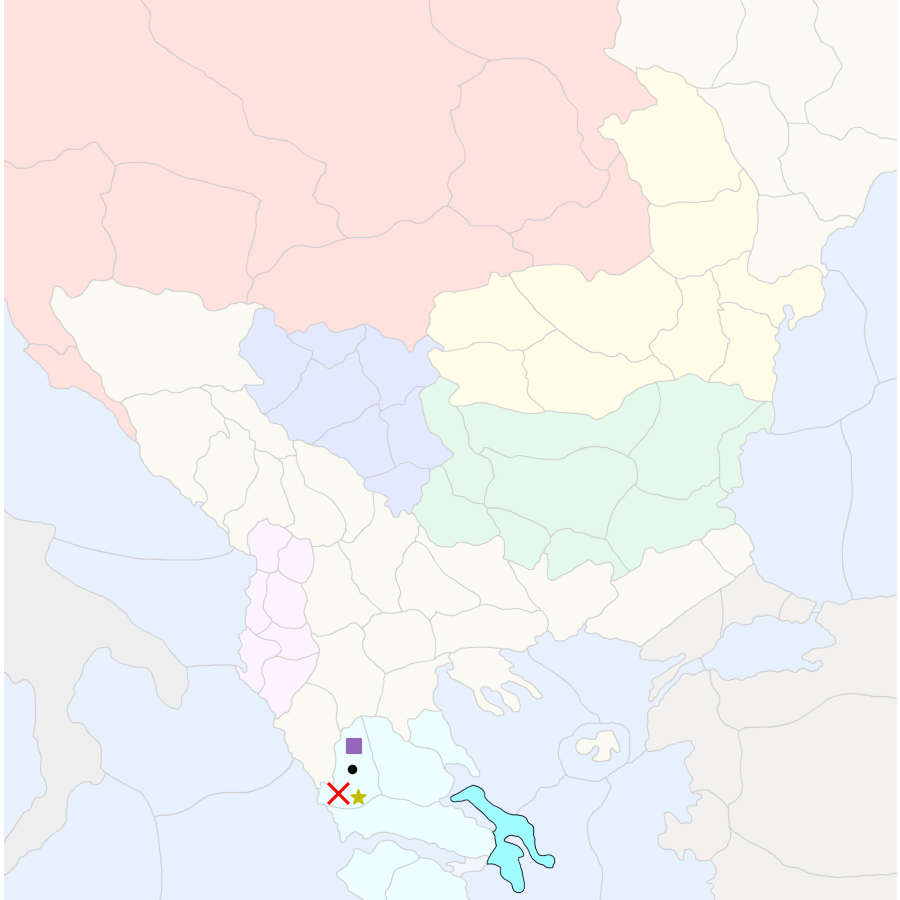

In [87]:
highlight(expand_labels(lbls==idx,5))

if 'rlocs' in locals() and name in rlocs:
    plt.scatter(*list(zip(*rlocs[name]))[::-1], s=100, c='r', marker='x');
if 'ulocs' in locals() and name in ulocs:
    plt.scatter(*list(zip(*ulocs[name]))[::-1], s=50, c='k', marker='.');
if 'llocs' in locals() and name in llocs:
    plt.scatter(*list(zip(*llocs[name]))[::-1], s=50, c='C4', marker='s');
if 'slocs' in locals() and name in slocs:
    plt.scatter(*list(zip(*slocs[name]))[::-1], s=50, c='y', marker='*');

if 'clocs' in locals() and name in clocs:
    if isinstance(clocs[name], dict):
        for d, (y,x) in clocs[name].items():
            plt.text(x,y,s=d, ha='center', va='center', backgroundcolor='w');
    else:
        plt.scatter(*list(zip(*clocs[name]))[::-1], s=50, c='C0', marker='v');
if 'crlocs' in locals() and name in crlocs:
    if isinstance(crlocs[name], dict):
        for d, (y,x) in crlocs[name].items():
            plt.text(x,y,s=f'r-{d}', ha='center', va='center', backgroundcolor='w');
    else:
        plt.scatter(*list(zip(*crlocs[name]))[::-1], s=50, c='C1', marker='x');


In [88]:
locsnames = {
    'label': llocs,
    'sc': slocs,
    'unit': ulocs,
    'retreat': rlocs,
    'coast-unit': clocs,
    'coast-retreat': crlocs,
}
for typ, lcs in locsnames.items():
    for name, lc in lcs.items():
        if 'locs' not in regs[name]:
            regs[name]['locs'] = {}
        regs[name]['locs'][typ] = lc

In [151]:
for node in graph.values():
    if node['name'] in slocs:
#     if 'sc' in node['locs']:
        node['sc'] = 1

In [19]:
# for node in graph.values():
#     if 'fleet' in node['edges'] and 'army' in node['edges']:
#         node['type'] = 'coast'

In [89]:
save_yaml(graph, root/'graph.yaml')

# Fix Edges

In [90]:
graph = load_yaml(root/'graph.yaml')
len(graph)

97

In [91]:
def _split_name(x):
    base, *coast = x.split('-')
    if not len(coast):
        return base, None
    return base, coast[0]

In [92]:
for name, node in tqdm(graph.items()):
    eds = node['edges']
    if 'army' in eds:
        for e in eds['army']:
            if name not in graph[e]['edges']['army']:
                graph[e]['edges']['army'].append(name)
    if 'fleet' in eds:
        if isinstance(eds['fleet'], list):
            bad = []
            for e in eds['fleet']:
                b, c = _split_name(e)
                ns = graph[b]['edges']['fleet']
                if c is not None:
                    ns = ns[c]
                if isinstance(ns,dict):
                    bad.append(e)
                elif name not in ns:
                    try:
                        ns.append(name)
                    except AttributeError:
                        print(name, e, b, c, ns)
                        raise
            for b in bad:
                eds['fleet'].remove(b)
        else:
            for coast, es in eds['fleet'].items():
                bad = []
                start = f'{name}-{coast}'
                for e in es:
                    b, c = _split_name(e)
                    ns = graph[b]['edges']['fleet']
                    if c is not None:
                        ns = ns[c]
                    if isinstance(ns,dict):
                        bad.append(e)
                    elif start not in ns:
                        ns.append(start)
                for b in bad:
                    es.remove(b)
            pass

  0%|          | 0/97 [00:00<?, ?it/s]

In [94]:

name = 'PER'

node = graph[name]
node

{'ID': 79,
 'edges': {'army': ['VAL', 'KOR', 'IOA', 'VLR'],
  'fleet': ['IOA', 'VLR', 'AIC']},
 'env': 'land',
 'locs': {'label': [[3311.468332615252, 1480.8849633778543]],
  'retreat': [[3417.53785488959, 1327.5]],
  'sc': [[3474.2119914346895, 1384.026766595289]],
  'unit': [[3352.53785488959, 1379.5]]},
 'name': 'PER',
 'sc': 1,
 'tiles': [115],
 'type': 'coast'}

<IPython.core.display.Javascript object>


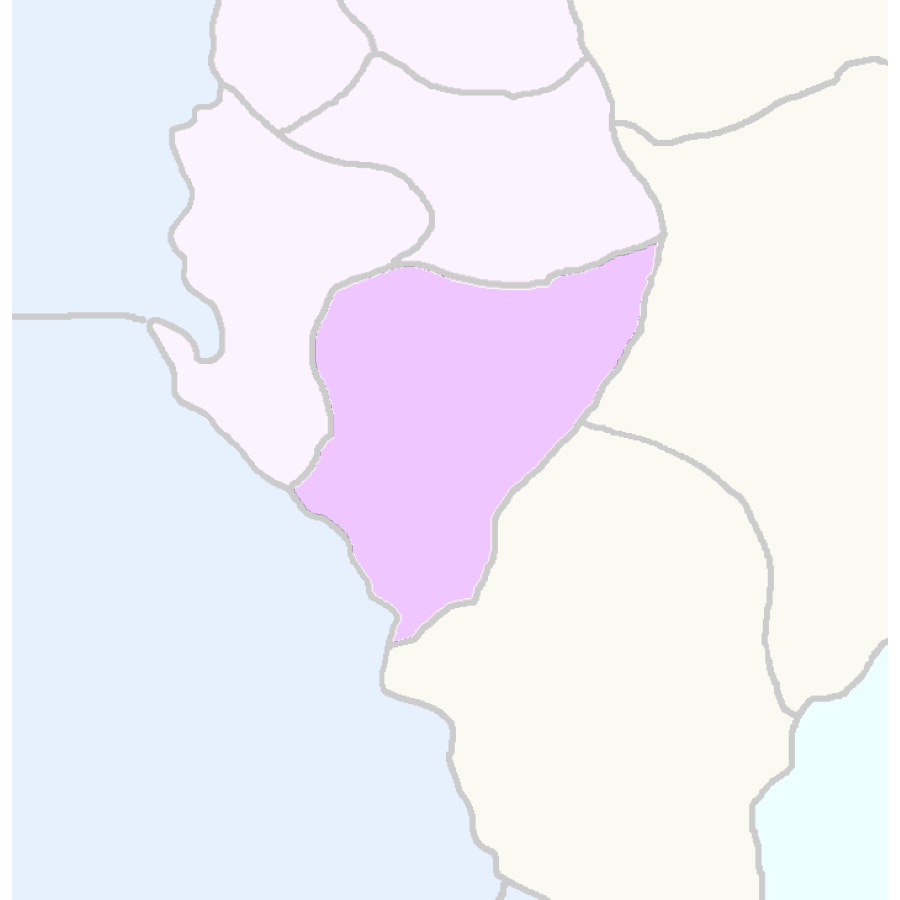

In [96]:
highlight(lbls==node['ID'])